In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Stop SparkSession jika ada yang aktif
try:
    spark.stop()
except:
    pass

# Buat spark session
spark = SparkSession.builder \
    .appName("ChurnPredictionEDA") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

SparkSession dan library visualisasi siap.


In [5]:
master_table_path = "data/master_feature_table.parquet"

print(f"Memuat data dari {master_table_path}...")
master_table_spark = spark.read.parquet(master_table_path)
master_table_spark.cache()

# print schema
print("Skema master_table:")
master_table_spark.printSchema()

# convert to Pandas DataFrame for visualization
print("\nMengonversi ke Pandas DataFrame")
master_table_pd = master_table_spark.toPandas()

# display data
display(master_table_pd.head())

Memuat data dari data/master_feature_table.parquet...
Skema master_table:
root
 |-- msno: string (nullable = true)
 |-- is_churn: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- age_group: string (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- membership_duration_days: integer (nullable = true)
 |-- total_transactions: long (nullable = true)
 |-- total_payment_plan_days: long (nullable = true)
 |-- avg_discount: double (nullable = true)
 |-- count_auto_renew: long (nullable = true)
 |-- count_cancel: long (nullable = true)
 |-- last_transaction_date: integer (nullable = true)
 |-- last_expiry_date: integer (nullable = true)
 |-- avg_num_25: double (nullable = true)
 |-- avg_num_50: double (nullable = true)
 |-- avg_num_75: double (nullable = true)
 |-- avg_num_985: double (nullable = true)
 |-- avg_num_100: double (nullable = true)
 |-- avg_daily_secs: double (nullable = true)
 |-- total_active_days: long (nullable = true)
 |-- total_unq_songs:

,msno,is_churn,city,age_group,registered_via,membership_duration_days,total_transactions,total_payment_plan_days,avg_discount,count_auto_renew,...,last_expiry_date,avg_num_25,avg_num_50,avg_num_75,avg_num_985,avg_num_100,avg_daily_secs,total_active_days,total_unq_songs,percent_songs_completed
0,+/2VbA8cwltucnJxl+EvDfjz/SUGdhIFNpt3LjJq4fw=,0,22,0-17 (Remaja),4,427,14,420,0.000000,0,...,20170421,6.379032,1.048387,0.481183,0.395161,22.032258,5143.368255,372,8630,0.744475
1,+/Pjxd4EFpdwtYEFs5erJ9DnyEq7RwQ5YTl/AxJhvqI=,0,1,Unknown,3,1263,6,157,0.000000,5,...,20170516,6.440000,1.440000,0.760000,0.666667,26.880000,6541.953173,75,1589,0.711991
2,+/g0m+e8jYjfEBUs29HU4Qb9fIeN9e1qx2WTeH2/jSs=,0,13,26-35 (Dewasa),9,3584,27,784,-5.518519,27,...,20170410,0.941718,0.466258,0.306748,0.730061,44.647239,11060.089877,326,14312,0.858686
3,+01JL4StZOE8ofp3hp23+bUbsE0PwvDTZW5jCmVX/Rg=,0,1,Unknown,9,715,19,570,0.000000,0,...,20170420,4.133005,3.054187,1.396552,1.071429,12.472906,3976.822586,406,4872,0.536609
4,+0Yw9EKLMJTJ4wVZUPPKakxzh/GhwQGJrSy1Sgyezfg=,1,5,18-25 (Muda),3,858,19,540,-7.842105,0,...,20170413,13.020930,1.269767,0.909302,1.341860,23.306977,6383.185726,430,14388,0.597435


Memulai visualisasi demografi...


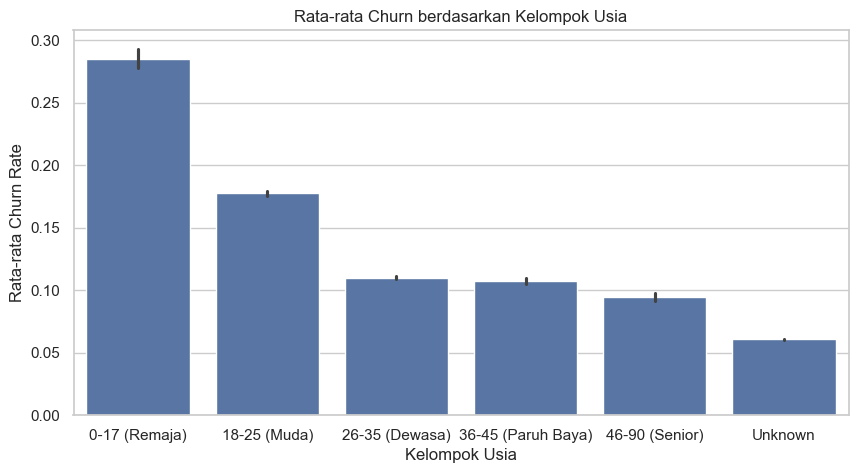

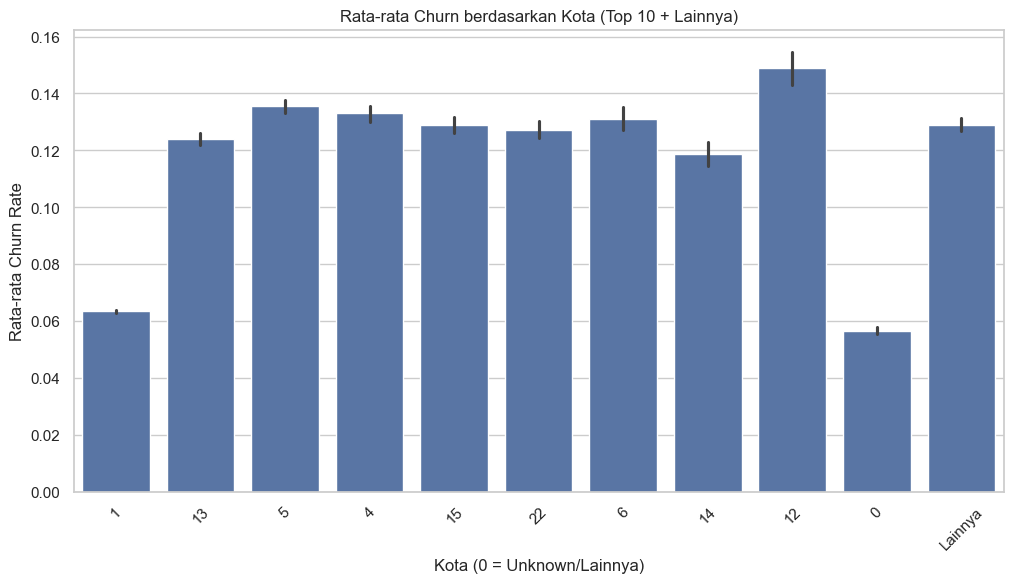

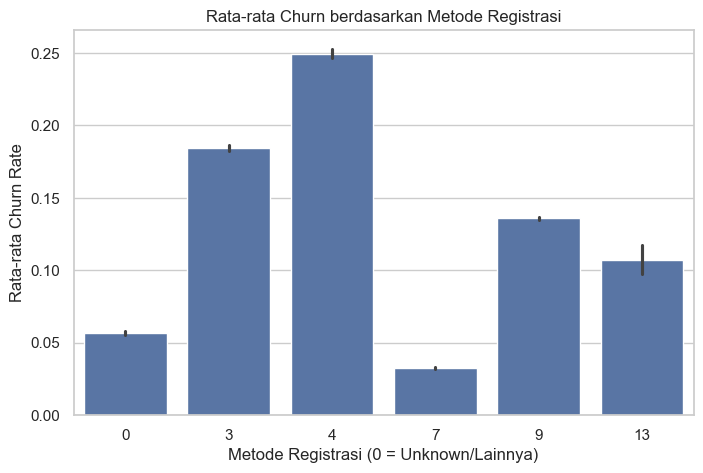

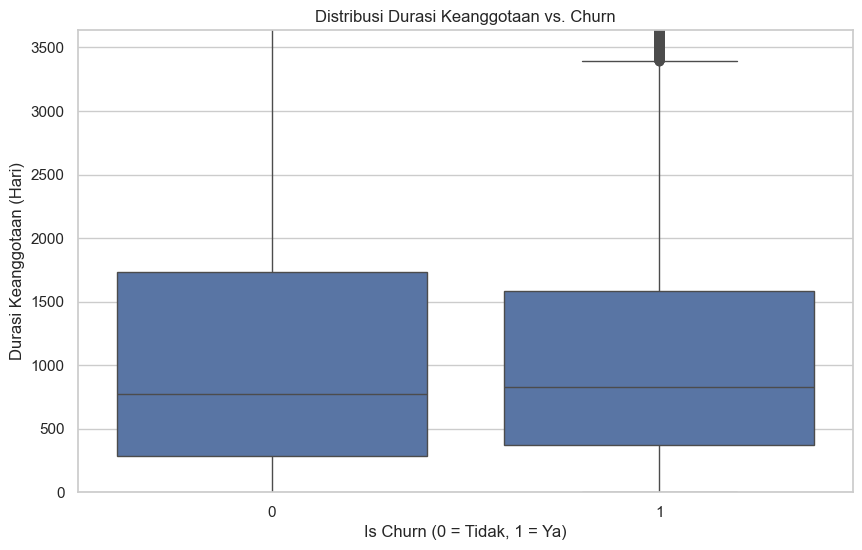

Visualisasi demografi selesai.


In [ ]:
print("Memulai visualisasi demografi...")

# Isi nilai None/NULL sebelum plotting
# Ganti None di 'age_group' (string) dengan 'Unknown'
master_table_pd['age_group'] = master_table_pd['age_group'].fillna('Unknown')
# Ganti None di 'city' (int) dengan 0 (bisa dianggap kategori 'Unknown/Lainnya')
master_table_pd['city'] = master_table_pd['city'].fillna(0)
# Ganti None di 'registered_via' (int) dengan 0 (bisa dianggap kategori 'Unknown/Lainnya')
master_table_pd['registered_via'] = master_table_pd['registered_via'].fillna(0)

# Plot 1: Rata-rata Churn berdasarkan Kelompok Usia (age_group)
plt.figure(figsize=(10, 5))
sns.barplot(
    data=master_table_pd, 
    x='age_group', 
    y='is_churn', 
    order=sorted(master_table_pd['age_group'].unique())
)
plt.title('Rata-rata Churn berdasarkan Kelompok Usia')
plt.ylabel('Rata-rata Churn Rate')
plt.xlabel('Kelompok Usia')

# save gambar
plt.savefig("age_group_vs_churn.png", bbox_inches='tight')
plt.show()

# Plot 2: Rata-rata Churn berdasarkan Kota (city)
plt.figure(figsize=(12, 6))
# Ambil Top 10 kota + 'Lainnya' untuk kebersihan plot
top_cities = master_table_pd['city'].value_counts().nlargest(10).index
plot_data_city = master_table_pd.copy()
# Buat kolom baru untuk plot, selain Top 10 akan jadi 'Lainnya'
plot_data_city['city_plot'] = plot_data_city['city'].apply(lambda x: str(x) if x in top_cities or x == 0 else 'Lainnya')
# sort
order_cities = [str(c) for c in top_cities if c != 0]
if 0 in top_cities.values:
    order_cities.append('0')
if 'Lainnya' in plot_data_city['city_plot'].unique():
    order_cities.append('Lainnya')

sns.barplot(data=plot_data_city, x='city_plot', y='is_churn', order=order_cities)
plt.title('Rata-rata Churn berdasarkan Kota (Top 10 + Lainnya)')
plt.ylabel('Rata-rata Churn Rate')
plt.xlabel('Kota (0 = Unknown/Lainnya)')
plt.xticks(rotation=45)
# save gambar
plt.savefig("city_vs_churn.png", bbox_inches='tight')
plt.show()

# Plot 3: Rata-rata Churn berdasarkan Metode Registrasi (registered_via)
plt.figure(figsize=(8, 5))
# Ambil urutan berdasarkan ID registrasi
reg_order = sorted(master_table_pd['registered_via'].unique())
sns.barplot(data=master_table_pd, x='registered_via', y='is_churn', order=reg_order)
plt.title('Rata-rata Churn berdasarkan Metode Registrasi')
plt.ylabel('Rata-rata Churn Rate')
plt.xlabel('Metode Registrasi (0 = Unknown)')
# save gambar
plt.savefig("registered_via_vs_churn.png", bbox_inches='tight')
plt.show()

# Plot 4: Distribusi Durasi Keanggotaan (membership_duration_days) vs. Churn
plt.figure(figsize=(10, 6))
# Ganti None di kolom dengan 0
master_table_pd['membership_duration_days'] = master_table_pd['membership_duration_days'].fillna(0)

sns.boxplot(data=master_table_pd, x='is_churn', y='membership_duration_days')
plt.title('Distribusi Durasi Keanggotaan vs. Churn')
plt.xlabel('Is Churn (0 = Tidak, 1 = Ya)')
plt.ylabel('Durasi Keanggotaan (Hari)')
# batasi sumbu y ke quantil 95% agar outlier spy plot ga rusak
q95 = master_table_pd['membership_duration_days'].quantile(0.95)
# pastiin q95 tidak 0, jika ya, beri batas atas default
if q95 == 0:
    q95 = master_table_pd['membership_duration_days'].max()
    
plt.ylim(0, q95)

plt.savefig("membership_duration_vs_churn.png", bbox_inches='tight')
plt.show()

print("Visualisasi demografi selesai.")

## Interpretasi Demografi
#### Plot 1: Rata-rata Churn based on age_group
Grup "Unknown" justru merupakan salah satu grup yang paling loyal, dengan churn rate terendah kedua (sekitar 6%). Pengguna remaja (0-17) adalah yang paling berisiko untuk churn (~28%), diikuti oleh grup "18-25 (Muda)" (~17.5%).

#### Plot 2: Rata-rata Churn based on city
Terdapat variasi, namun yang paling menonjol adalah Kota '12' sebagai yang paling berisiko churn. Sebaliknya, Kota '0' (Unknown) dan Kota '1' adalah dua grup yang paling loyal (churn rate terendah, di kisaran 6%).

#### Plot 3: Rata-rata Churn based on registred_via
Metode '4' menghasilkan pengguna yang paling mudah churn. Sebaliknya, metode '7' menghasilkan pengguna yang paling loyal. Metode '3' juga berisiko tinggi (~18%).

#### Plot 4: Distribusi Membership_duration_days
Durasi Keanggotaan BUKANLAH prediktor yang baik untuk churn. Pengguna yang churn dan yang loyal memiliki profil durasi keanggotaan yang hampir identik. Ini membatalkan asumsi awal kita(smkn lama smkn loyal) dan sangat penting untuk feature selection nanti.

Memulai visualisasi transaksi...


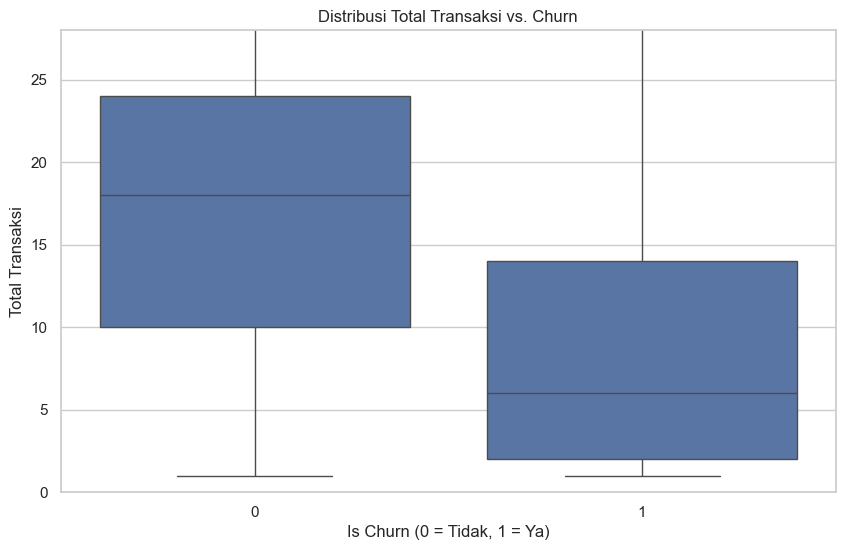

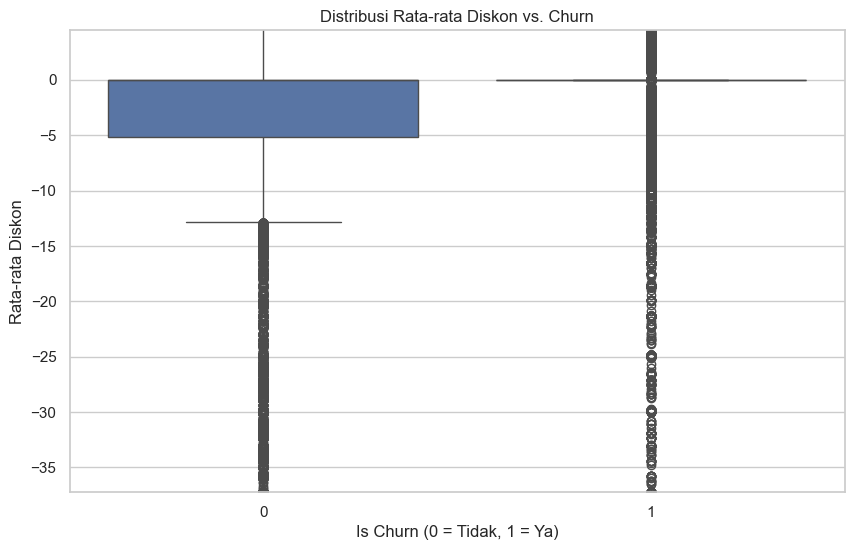

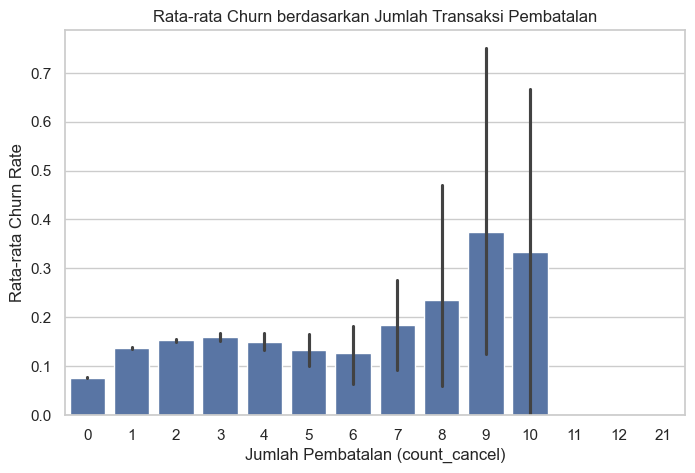

In [ ]:
print("Memulai visualisasi transaksi...")

# Plot 1: Distribusi Total Transaksi (total_transactions) vs. Churn 
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_table_pd, x='is_churn', y='total_transactions')
plt.title('Distribusi Total Transaksi vs. Churn')
plt.xlabel('Is Churn (0 = Tidak, 1 = Ya)')
plt.ylabel('Total Transaksi')
# Batasi sumbu y ke quantil 95%
plt.ylim(0, master_table_pd['total_transactions'].quantile(0.95))
plt.show()

# Plot 2: Distribusi Rata-rata Diskon (avg_discount) vs. Churn 
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_table_pd, x='is_churn', y='avg_discount')
plt.title('Distribusi Rata-rata Diskon vs. Churn')
plt.xlabel('Is Churn (0 = Tidak, 1 = Ya)')
plt.ylabel('Rata-rata Diskon')
# Batasi sumbu y agar lebih jelas
plt.ylim(master_table_pd['avg_discount'].quantile(0.05), master_table_pd['avg_discount'].quantile(0.95))
plt.show()

# Plot 3: Rata-rata Churn berdasarkan Jumlah Pembatalan (count_cancel) 
plt.figure(figsize=(8, 5))
sns.barplot(data=master_table_pd, x='count_cancel', y='is_churn')
plt.title('Rata-rata Churn berdasarkan Jumlah Transaksi Pembatalan')
plt.ylabel('Rata-rata Churn Rate')
plt.xlabel('Jumlah Pembatalan (count_cancel)')
plt.show()

## Interpretasi Transactions
### Plot 5: Distribusi total transactions
Pengguna yang churn memiliki jumlah transaksi jauh lbh dikit. Pengguna yang loyal memiliki median transaksi lebih tinggi dan sebaran yang lebih luas (banyak transaksi berkali"). Jadi semakin sering membayar, semakin loyal mrk.

### Plot 6: Distribusi avg discount
Distribusinya berbeda, box plot untuk yang tidak churn punya rentang sebaran yg lbh lebar, terutama ke arah nilai negatif(actual_amount_paid > plan_list_price, mungkin upgrade (?)). Pengguna yg churn distribusinya lebih sempit dan terpusat di 0.

### Plot 7: Rata-rata Churn based on count_cancel
Plot ini menunjukkan sebuah tren:
- Baseline (count_cancel = 0): Pengguna yang tidak pernah membatalkan transaksi memiliki churn rate terendah, yaitu di bawah 0.10 (sekitar 7.5%). Ini paling loyal.

- Satu Kali Batal (count_cancel = 1): Begitu pengguna batalin satu kali saja, churn rate mereka langsung naik dua kali lipat jadi ~15%.

- Tren Kenaikan (count_cancel > 1): Semakin sering seseorang membatalkan (2 kali, 3 kali, 7 kali), rata-rata churn rate mereka juga ikut naik secara bertahap.

- Puncak (count_cancel 8-10): Churn rate melonjak drastis pada pengguna yang batalin 8, 9, atau 10 kali, mencapai puncaknya di 33% - 37%. (error bar yang panjang di angka 9 dan 10 menunjukkan jumlah pengguna di grup lebih dikit, sehingga variasinya besar, tapi rata-ratanya tetap sangat tinggi).


Memulai visualisasi perilaku log...


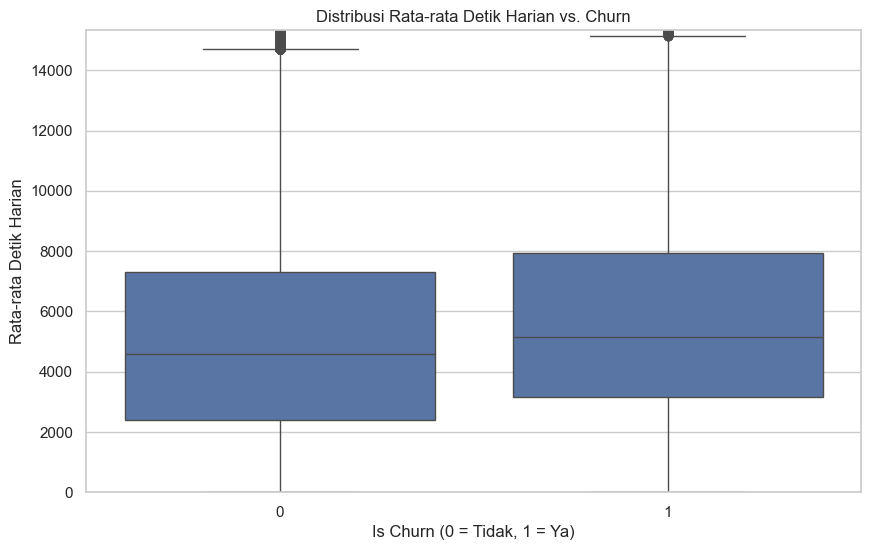

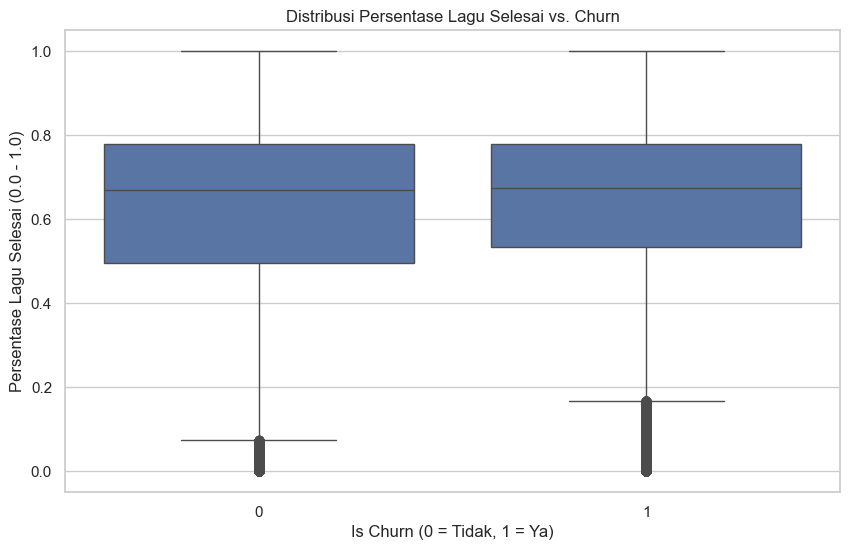

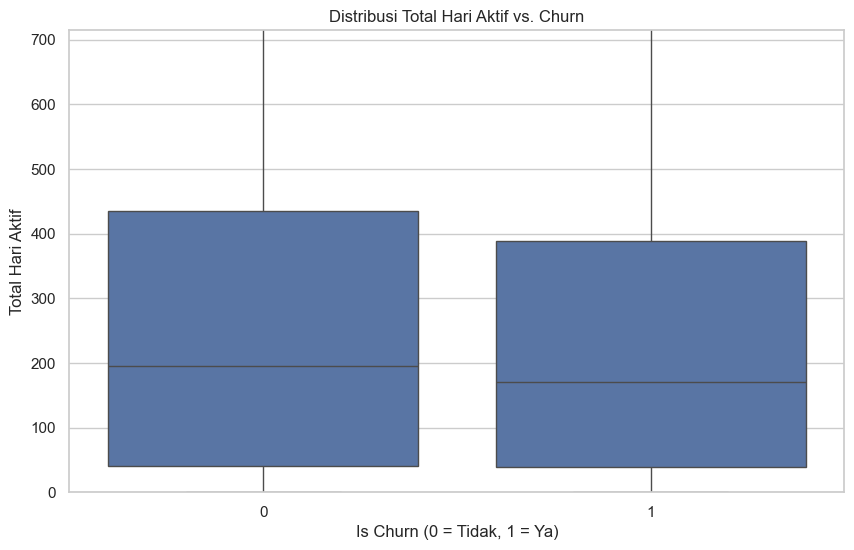

In [ ]:
print("Memulai visualisasi perilaku log...")

# Plot 1: Distribusi Rata-rata Detik Harian (avg_daily_secs) vs. Churn
plt.figure(figsize=(10, 6))

sns.boxplot(data=master_table_pd, x='is_churn', y='avg_daily_secs') 
plt.title('Distribusi Rata-rata Detik Harian vs. Churn')
plt.xlabel('Is Churn (0 = Tidak, 1 = Ya)')
plt.ylabel('Rata-rata Detik Harian')
# Batasi sumbu y ke quantil 95%
plt.ylim(0, master_table_pd['avg_daily_secs'].quantile(0.95))
plt.show()

# Plot 2: Distribusi Persentase Lagu Selesai (percent_songs_completed) vs. Churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_table_pd, x='is_churn', y='percent_songs_completed')
plt.title('Distribusi Persentase Lagu Selesai vs. Churn')
plt.xlabel('Is Churn (0 = Tidak, 1 = Ya)')
plt.ylabel('Persentase Lagu Selesai (0.0 - 1.0)')
plt.show()

# Plot 3: Distribusi Total Hari Aktif (total_active_days) vs. Churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_table_pd, x='is_churn', y='total_active_days')
plt.title('Distribusi Total Hari Aktif vs. Churn')
plt.xlabel('Is Churn (0 = Tidak, 1 = Ya)')
plt.ylabel('Total Hari Aktif')
# Batasi sumbu y ke quantil 95%
plt.ylim(0, master_table_pd['total_active_days'].quantile(0.95))
plt.show()

## Interpretasi Log
### Plot 8: Rata-data detik harian
Distribusi kedua grup ini hampir mirip. Pengguna yang churn justru punya rata-rata (median) waktu dengar harian yang sedikit lebih lama. Ini membatalkan asumsi kita. Fitur ini sepertinya memiliki sinyal yang lemah atau bahkan berlawanan.

### Plot 8: Rata-data detik harian
Fitur percent_songs_completed tampaknya tidak memiliki sinyal prediktif sama sekali. Baik pengguna loyal maupun yang churn memiliki kebiasaan skip lagu yang sangat mirip.

### Plot 9: Total active days
Ada sinyal yang lemah di sini. Pengguna yang churn cenderung memiliki hari aktif yang sedikit lebih sedikit, tetapi distribusinya sangat tumpang tindih (overlapping) dengan pengguna loyal.

In [17]:
master_table_path_3 = "data/master_feature_table_3.parquet"

print(f"Memuat data dari {master_table_path_3}...")
master_table_spark_3 = spark.read.parquet(master_table_path_3)
try:
    # 1. Hapus versi LAMA (jika ada) dari memori
    master_table_spark_3.unpersist() 
    print("Cache master_table_spark_3 lama berhasil dihapus.")
except NameError:
    print("Cache master_table_spark_3 belum ada, lanjut membuat baru.")
    
master_table_spark_3.cache()

# print schema
print("Skema master_table:")
master_table_spark_3.printSchema()

# convert to Pandas DataFrame for visualization
print("\nMengonversi ke Pandas DataFrame")
master_table_pd_3 = master_table_spark_3.toPandas()

# display data
display(master_table_pd_3.head())

Memuat data dari data/master_feature_table_3.parquet...
Cache master_table_spark_3 lama berhasil dihapus.
Skema master_table:
root
 |-- msno: string (nullable = true)
 |-- is_churn: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- age_group: string (nullable = true)
 |-- registered_via: integer (nullable = true)
 |-- membership_duration_days: integer (nullable = true)
 |-- total_transactions: long (nullable = true)
 |-- total_payment_plan_days: long (nullable = true)
 |-- avg_discount: double (nullable = true)
 |-- count_auto_renew: long (nullable = true)
 |-- count_cancel: long (nullable = true)
 |-- last_transaction_date: integer (nullable = true)
 |-- last_expiry_date: integer (nullable = true)
 |-- days_since_last_activity: integer (nullable = true)
 |-- total_secs_last_30d: double (nullable = true)
 |-- active_days_last_30d: long (nullable = true)
 |-- total_secs_last_90d: double (nullable = true)
 |-- active_days_last_90d: long (nullable = true)
 |-- activity_r

,msno,is_churn,city,age_group,registered_via,membership_duration_days,total_transactions,total_payment_plan_days,avg_discount,count_auto_renew,...,last_expiry_date,days_since_last_activity,total_secs_last_30d,active_days_last_30d,total_secs_last_90d,active_days_last_90d,activity_ratio_secs,percent_complete_last_30d,lifetime_active_days,lifetime_unq_songs
0,++xbPSy/npsr5jYR8uiyRh2jsZ7IdOD5gCGx2BzYrkM=,0,22,18-25 (Muda),9,2541,21,855,-7.095238,0,...,20170831,0,154958.330,27,401382.140,82,0.628829,0.810705,748,23171
1,+/RgFgqC+fsCKMQCBdtcwR4Jj0zjTDW0CSq7C/9vvoI=,0,13,18-25 (Muda),9,3113,21,603,-7.095238,21,...,20170511,0,506308.559,30,1842344.768,90,0.378963,0.893627,778,45464
2,+0fgBZzlFyXZqtdTd2scisNTu/Aq/PkC2SgCnFzNkHA=,0,13,36-45 (Paruh Baya),7,2101,29,840,-5.137931,29,...,20170424,0,58054.556,10,115734.991,37,1.006486,0.238158,447,9622
3,+1kZsXKKkkySy0txWHp+prLJNjIPpRven+Xa3f0Y+qw=,0,15,36-45 (Paruh Baya),9,817,22,604,-0.045455,20,...,20170415,0,31621.768,12,293868.201,60,0.120580,0.913580,605,9135
4,+26LIV+I6MBmFPH7zNaJ0xnerqm0AfG45bomQLucXUc=,0,4,0-17 (Remaja),13,132,5,150,0.000000,5,...,20170418,3,38066.760,9,101783.136,35,0.597441,0.612440,57,662


Memulai visualisasi perilaku log (FITUR BARU)...


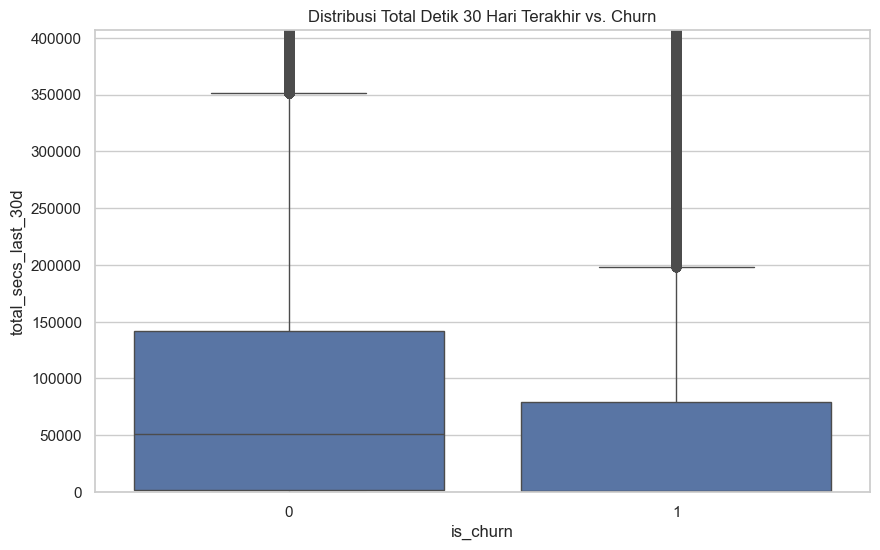

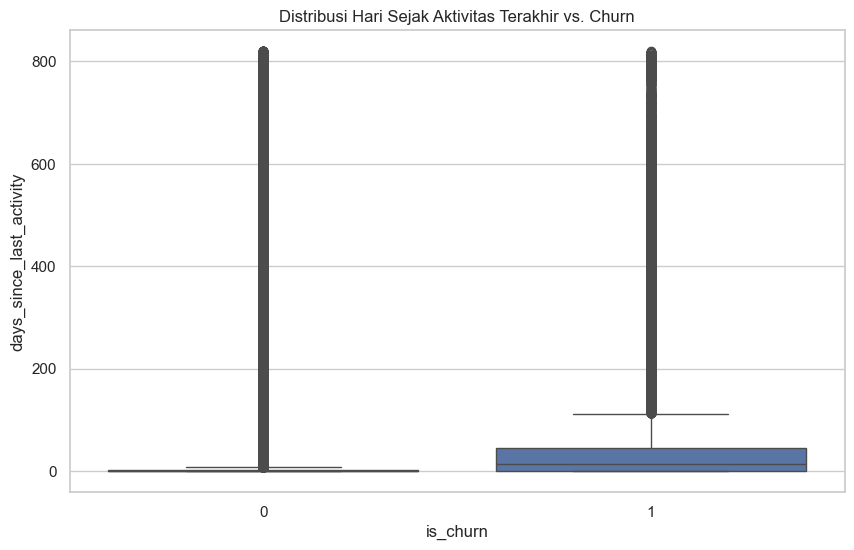

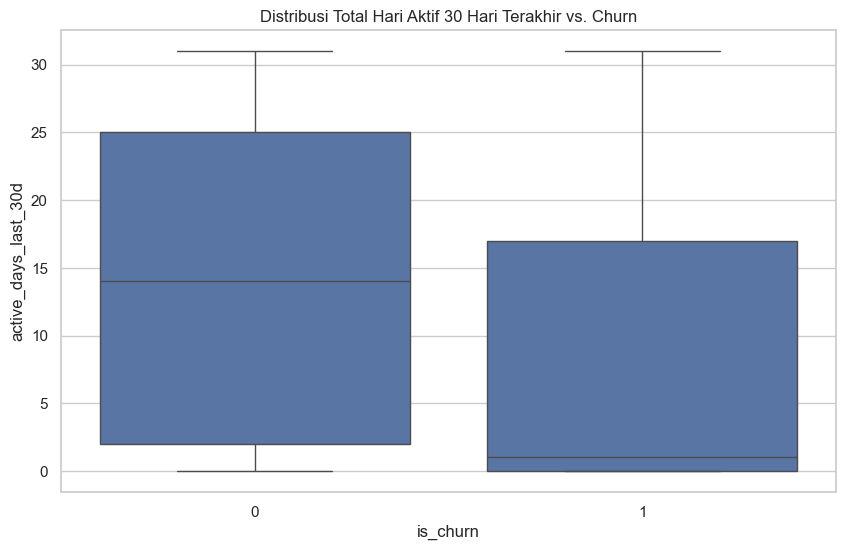

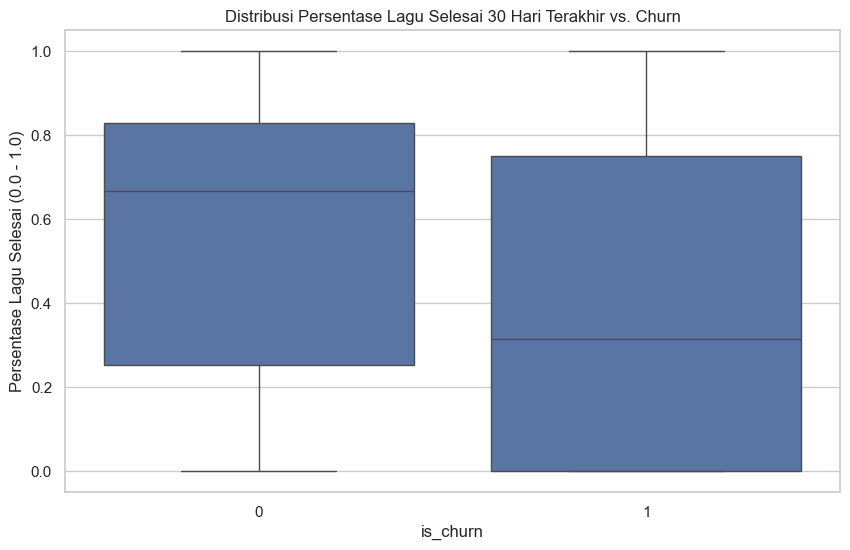

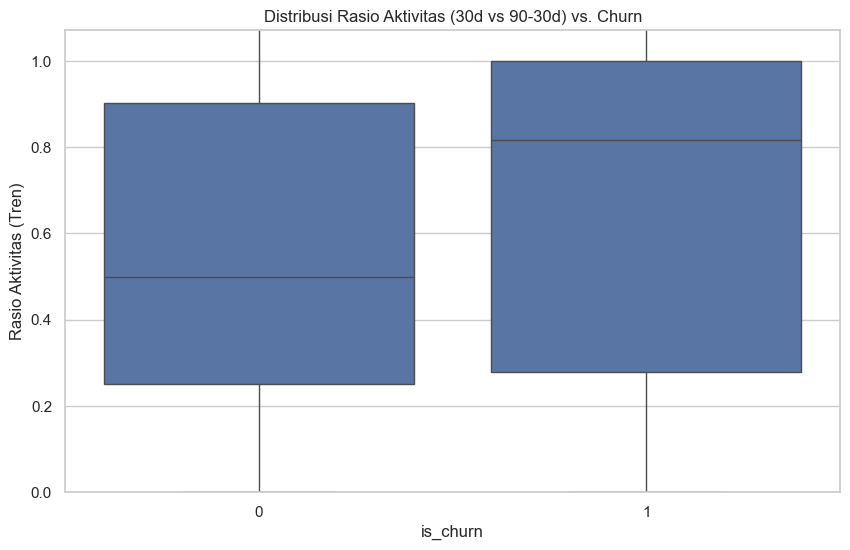

In [ ]:
# Features lbh fokus ke recency + perilaku terbary (last 30 days)
print("Memulai visualisasi perilaku log")

# Plot 1: Distribusi Total Detik 30 Hari Terakhir vs. Churn
# Hipotesis: Pengguna churn akan memiliki total detik yang sangat rendah.
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_table_pd_3, x='is_churn', y='total_secs_last_30d')
plt.title('Distribusi Total Detik 30 Hari Terakhir vs. Churn')
# Batasi outlier agar plot utama lebih jelas
q95 = master_table_pd_3['total_secs_last_30d'].quantile(0.95)
if q95 == 0: q95 = master_table_pd_3['total_secs_last_30d'].max()
plt.ylim(0, q95) 
plt.show()

# Plot 2: Distribusi Hari Sejak Aktivitas Terakhir vs. Churn
# Hipotesis: Pengguna churn sudah lama tidak aktif (angka tinggi).
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_table_pd_3, x='is_churn', y='days_since_last_activity')
plt.title('Distribusi Hari Sejak Aktivitas Terakhir vs. Churn')
plt.show()

# Plot 3: Distribusi Total Hari Aktif 30 Hari Terakhir vs. Churn
# Hipotesis: Pengguna churn memiliki hari aktif yang sangat sedikit (mendekati 0).
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_table_pd_3, x='is_churn', y='active_days_last_30d')
plt.title('Distribusi Total Hari Aktif 30 Hari Terakhir vs. Churn')
plt.show()

# Plot 4: Distribusi Persentase Lagu Selesai 30 Hari Terakhir vs. Churn
# Hipotesis: Pengguna churn lebih sering skip lagu BARU-BARU INI (nilai lebih rendah).
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_table_pd_3, x='is_churn', y='percent_complete_last_30d')
plt.title('Distribusi Persentase Lagu Selesai 30 Hari Terakhir vs. Churn')
plt.ylabel('Persentase Lagu Selesai (0.0 - 1.0)')
plt.show()

# Plot 5: Distribusi Rasio Aktivitas (Tren) vs. Churn
# Hipotesis: Pengguna churn menunjukkan penurunan aktivitas (rasio < 1.0).
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_table_pd_3, x='is_churn', y='activity_ratio_secs')
plt.title('Distribusi Rasio Aktivitas (30d vs 90-30d) vs. Churn')
plt.ylabel('Rasio Aktivitas (Tren)')
# Batasi sumbu y karena rasio bisa sangat besar/kecil. Fokus di antara 0 dan 3.
plt.ylim(0, master_table_pd_3['activity_ratio_secs'].quantile(0.90)) 
plt.show()

Hasil plot ini better dari yg sblmnya yang lifetime (lbh fokus ke recency dan perilaku terbaru (last 30 days))

# Plot total secs last 30 days
- Churn = 0 (Loyal): Box plot (kotaknya) jauh lebih tinggi. Median (garis tengah) ada di sekitar 50.000 detik. Ini adalah pengguna yang sangat aktif di bulan terakhir.

- Churn = 1: Box plot jauh lebih rendah. Median-nya sangat dekat dengan 0 (mungkin sekitar 5.000 detik). Ini berarti 50% dari pengguna yang churn hampir tidak mendengarkan apa pun dalam 30 hari terakhir.

--> penurunan drastim dlm volume mendengarkan di 30 hari terakhir (prediktor kuat churn)

# Plot hari sejak last activity
- Churn = 0 (Loyal): Kotaknya "gepeng" atau kolaps di angka 0. Ini berarti mayoritas (setidaknya 75%) pengguna loyal aktif hingga hari terakhir (atau 1-2 hari terakhir) dari periode data.

- Churn = 1: Kotaknya jelas terlihat dan lebih tinggi. Mediannya ada di sekitar 25-30 hari. Ini berarti 50% pengguna yang churn sudah tidak aktif selama hampir sebulan sebelum churn terdeteksi.

--> pengguna churn "hilang" terlebih dahulu, predikor oke

# plot total days active last 30 days
- Churn = 0 (Loyal): Median hari aktif tinggi, sekitar 14 hari. Pengguna loyal login dan mendengarkan setidaknya selama 14 hari dalam sebulan terakhir.

- Churn = 1: Median hari aktif sangat rendah, mungkin hanya 1 atau 2 hari. 50% pengguna churn hampir tidak login sama sekali di bulan terakhir.

--> pengguna churn ga cuman mengurangi volume harian (plot 1), tapi juga frekuensi harian.

# plot perc lagu selesai 30 hari terakhir
- Churn = 0 (Loyal): Median persentase selesai lebih tinggi (sekitar 67%).

- Churn = 1: Median persentase selesai jelas lebih rendah (sekitar 33%).

--> di bulan terakhir mereka, pengguna yang churn memang lbh sering skip lagu atau dengerin lbh sedikit lagu sampai selesai (frustasi/bosan)

# plot ratio activity (trend)
- Churn = 0 (Loyal): Median rasio ada di sekitar 0.5.
--> activity mrk di last 30 days itu 50% aktivitas 2 bln sebelumnya.
- Churn = 1 (Ya): Median rasio justru lebih tinggi, sekitar 0.8.
--> high chance ini itu pengguna baru yang baru aktif 1-2 bulan lalu, punya aktivitas tinggi lalu langsung churn

--> prediktor baik

In [ ]:
# Hitung outliers per kolom numerik yang ada
from pyspark.sql import functions as F

df = master_table_spark_3

# Daftar kolom numerik untuk diperiksa
# exclude kolom id, label, dan kategorikal
numerical_cols = [
    "membership_duration_days",
    "total_transactions",
    "total_payment_plan_days",
    "avg_discount",
    "count_auto_renew",
    "count_cancel",
    "days_since_last_activity",
    "total_secs_last_30d",
    "active_days_last_30d",
    "total_secs_last_90d",
    "active_days_last_90d",
    "activity_ratio_secs",
    "percent_complete_last_30d",
    "lifetime_active_days",
    "lifetime_unq_songs"
]

# Ambil total baris untuk perhitungan persentase
total_count = df.count()

print(f"Total baris dalam DataFrame: {total_count:,}")
print("-" * 50)
print("Menghitung Outlier (Metode IQR 1.5x)...")
print("-" * 50)

outlier_results = []

# Loop melalui setiap kolom numerik
for col_name in numerical_cols:
    
    # 1. Hitung Q1 dan Q3
    # approxQuantile(kolom, [persentil], error_relatif)
    try:
        quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
        Q1 = quantiles[0]
        Q3 = quantiles[1]
    except Exception as e:
        print(f"Gagal menghitung kuantil untuk {col_name}: {e}")
        continue

    # 2. Hitung IQR dan Batas Atas/Bawah
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    # 3. Hitung jumlah outliers
    outlier_count = df.where(
        (F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound)
    ).count()
    
    # 4. Hitung persentase
    if total_count > 0:
        percentage = (outlier_count / total_count) * 100
    else:
        percentage = 0
    
    # Simpan hasil
    result = {
        "column": col_name,
        "outlier_count": outlier_count,
        "percentage": percentage,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound
    }
    outlier_results.append(result)

# Cetak hasil dengan rapi
print("\n--- Hasil Perhitungan Outlier ---")
for res in outlier_results:
    print(f"\nKolom: {res['column']}")
    print(f"  Batas (Bawah | Atas) : {res['lower_bound']:.2f} | {res['upper_bound']:.2f}")
    print(f"  Jumlah Outlier       : {res['outlier_count']:,} / {total_count:,} baris")
    print(f"  Persentase Outlier   : {res['percentage']:.2f} %")

Total baris dalam DataFrame: 1,082,190
--------------------------------------------------
Menghitung Outlier (Metode IQR 1.5x)...
--------------------------------------------------

--- Hasil Perhitungan Outlier ---

Kolom: membership_duration_days
  Batas (Bawah | Atas) : -1828.50 | 3791.50
  Jumlah Outlier       : 42,954 / 1,082,190 baris
  Persentase Outlier   : 3.97 %

Kolom: total_transactions
  Batas (Bawah | Atas) : -12.00 | 44.00
  Jumlah Outlier       : 620 / 1,082,190 baris
  Persentase Outlier   : 0.06 %

Kolom: total_payment_plan_days
  Batas (Bawah | Atas) : -295.50 | 1292.50
  Jumlah Outlier       : 1,039 / 1,082,190 baris
  Persentase Outlier   : 0.10 %

Kolom: avg_discount
  Batas (Bawah | Atas) : -11.94 | 7.17
  Jumlah Outlier       : 106,024 / 1,082,190 baris
  Persentase Outlier   : 9.80 %

Kolom: count_auto_renew
  Batas (Bawah | Atas) : -19.50 | 48.50
  Jumlah Outlier       : 454 / 1,082,190 baris
  Persentase Outlier   : 0.04 %

Kolom: count_cancel
  Batas (Bawah 